Este es nuestro toolbox para la preparacion de datos para un modelo:

In [1]:
# Nombre del módulo: toolbox_ML.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, f_oneway, kruskal
from scipy.stats import chi2_contingency

df = pd.read_csv("F:\Bootcamp\Online_Ds_Thebridge-Santi-Arias-\\titanic (3).csv")
# 1) describe_df

def describe_df(df):
    """
    Devuelve un DataFrame con la descripción de cada columna del DataFrame de entrada.
    Muestra:
       - Tipo de dato
       - Porcentaje de valores nulos
       - Número de valores únicos
       - Porcentaje de cardinalidad

    Argumentos:
    df (pd.DataFrame): El DataFrame a describir.

    Retorna:
    pd.DataFrame: DataFrame con la información solicitada para cada columna.
    """

    # Listas para ir almacenando la información
    col_names = []
    dtypes = []
    perc_nulls = []
    unique_vals = []
    perc_cardinality = []

    n_rows = len(df)

    for col in df.columns:
        col_names.append(col)
        dtypes.append(df[col].dtype)

        # Porcentaje de nulos
        null_count = df[col].isna().sum()
        perc_null = (null_count / n_rows) * 100 if n_rows else 0
        perc_nulls.append(round(perc_null, 2))

        # Número de valores únicos
        nunique = df[col].nunique(dropna=False)
        unique_vals.append(nunique)

        # Porcentaje de cardinalidad
        perc_card = (nunique / n_rows) * 100 if n_rows else 0
        perc_cardinality.append(round(perc_card, 2))

    # Construimos el DataFrame de salida
    summary_df = pd.DataFrame({
        'columna': col_names,
        'tipo': dtypes,
        '%_nulos': perc_nulls,
        'valores_unicos': unique_vals,
        '%_cardinalidad': perc_cardinality
    })

    return summary_df

describe_df(df)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sex          891 non-null    object 
 1   age          891 non-null    float64
 2   sibsp        891 non-null    int64  
 3   parch        891 non-null    int64  
 4   fare         891 non-null    float64
 5   class        891 non-null    object 
 6   who          891 non-null    object 
 7   adult_male   891 non-null    bool   
 8   embark_town  891 non-null    object 
 9   alive        891 non-null    object 
 10  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 64.5+ KB


 Devuelve un DataFrame con la descripción de cada columna del DataFrame de entrada.
    Muestra:
       - Tipo de dato
       - Porcentaje de valores nulos
       - Número de valores únicos
       - Porcentaje de cardinalidad

    Argumentos:
    df (pd.DataFrame): El DataFrame a describir.

    Retorna:
    pd.DataFrame: DataFrame con la información solicitada para cada columna.

In [7]:
def tipifica_variables(df, umbral_categoria=10, umbral_continua=0.2):
    """
    .
    """
    resultados = {
        'nombre_variable': [],
        'tipo_sugerido': []
    }
    n_rows = len(df)
    for col in df.columns:
        # Obtener el tipo de dato real
        dtype = df[col].dtype
        # Si el tipo de dato es 'category' o 'object', es categórico automáticamente
        if pd.api.types.is_categorical_dtype(dtype) or pd.api.types.is_object_dtype(dtype):
            tipo = 'Categórica'
        elif np.issubdtype(dtype, np.number):  # Si es numérico
            # Cardinalidad absoluta y relativa
            card_abs = df[col].nunique(dropna=False)
            card_rel = card_abs / n_rows if n_rows else 0
            # Clasificar como numérica
            if card_abs == 2:
                tipo = 'Binaria'
            elif card_abs < umbral_categoria:
                tipo = 'Categórica'
            else:
                if card_rel >= umbral_continua:
                    tipo = 'Numerica Continua'
                else:
                    tipo = 'Numerica Discreta'
        else:
            # Por seguridad, marcar como categórica cualquier otro tipo no esperado
            tipo = 'Categórica'
        # Guardar resultados
        resultados['nombre_variable'].append(col)
        resultados['tipo_sugerido'].append(tipo)
    return pd.DataFrame(resultados)
tipos_sujerido = tipifica_variables(df,10,0.2)
tipos_sujerido

C:\Users\samas\AppData\Local\Temp\ipykernel_6812\741975156.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) or pd.api.types.is_object_dtype(dtype):


,nombre_variable,tipo_sugerido
0,sex,Categórica
1,age,Numerica Discreta
2,sibsp,Categórica
3,parch,Categórica
4,fare,Numerica Continua
5,class,Categórica
6,who,Categórica
7,adult_male,Categórica
8,embark_town,Categórica
9,alive,Categórica


Asigna un tipo sugerido (Binaria, Categórica, Numérica Discreta o Numérica Continua)
    en función de la cardinalidad de cada columna del DataFrame y su tipo de dato.
    Argumentos:
    df (pd.DataFrame): El DataFrame a analizar.
    umbral_categoria (int): Umbral máximo de cardinalidad para considerar una variable como categórica.
    umbral_continua (float): Umbral (proporción) de cardinalidad por encima de la cual
                             se considera una variable como numérica continua.
    Retorna:
    pd.DataFrame: DataFrame con dos columnas: "nombre_variable" y "tipo_sugerido"

In [8]:
# 3) get_features_num_regression
# Nueva implementación

def get_features_num_regression(df, target_col, umbral_corr, pvalue=None, tipo_variables=None ):
    """
    Selecciona características numéricas que tengan una correlación significativa
    con la variable objetivo.

    Parámetros:
    df (pd.DataFrame): DataFrame que contiene las variables.
    target_col (str): Nombre de la columna objetivo.
    umbral_corr (float): Umbral mínimo de correlación (valor absoluto) para seleccionar las variables.
    pvalue (float, opcional): Valor p para filtrar variables con significancia estadística.
                              Por defecto es None.

    Retorna:
    list: Lista de nombres de columnas numéricas correlacionadas con el target,
          o None si los parámetros son inválidos.
    """
    # Validaciones de entrada
    if not isinstance(df, pd.DataFrame):
        print("El argumento 'df' debe ser un DataFrame.")
        return None

    if target_col not in df.columns:
        print(f"La columna objetivo '{target_col}' no se encuentra en el DataFrame.")
        return None

    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"La columna objetivo '{target_col}' debe ser numérica.")
        return None

    if not (0 <= umbral_corr <= 1):
        print("El valor de 'umbral_corr' debe estar entre 0 y 1.")
        return None

    if pvalue is not None and not (0 <= pvalue <= 1):
        print("El valor de 'pvalue' debe estar entre 0 y 1.")
        return None
    
    if tipo_variables is None or 'nombre_variable' not in tipo_variables.columns or 'tipo_sugerido' not in tipo_variables.columns:
        print("El argumento 'tipo_variables' debe ser un DataFrame generado por la función tipifica_variables.")
        return None
    
     # Inicializar lista para las columnas seleccionadas
    selected_features = []

    # Selección de columnas numéricas según la clasificación
    valid_types = ['Numerica Continua', 'Numerica Discreta']
    valid_cols = tipo_variables[tipo_variables['tipo_sugerido'].isin(valid_types)]['nombre_variable'].tolist()

    if target_col in valid_cols:
        valid_cols.remove(target_col)  # Excluir la columna objetivo

    for col in valid_cols:
        # Correlación (método Pearson simplificado usando .corr)
        corr = df[target_col].corr(df[col])

        if abs(corr) >= umbral_corr:
            if pvalue is not None:
                # Test de significancia estadística con pearsonr
                _, p_val = pearsonr(df[target_col], df[col])
                if p_val < pvalue:
                    selected_features.append(col)
            else:
                selected_features.append(col)

    return selected_features
x = get_features_num_regression(df,"age",0.02,0.03,tipos_sujerido)

x

['fare']

Selecciona características numéricas que tengan una correlación significativa
    con la variable objetivo.

    Parámetros:
    df (pd.DataFrame): DataFrame que contiene las variables.
    target_col (str): Nombre de la columna objetivo.
    umbral_corr (float): Umbral mínimo de correlación (valor absoluto) para seleccionar las variables.
    pvalue (float, opcional): Valor p para filtrar variables con significancia estadística.
                              Por defecto es None.

    Retorna:
    list: Lista de nombres de columnas numéricas correlacionadas con el target,
          o None si los parámetros son inválidos.

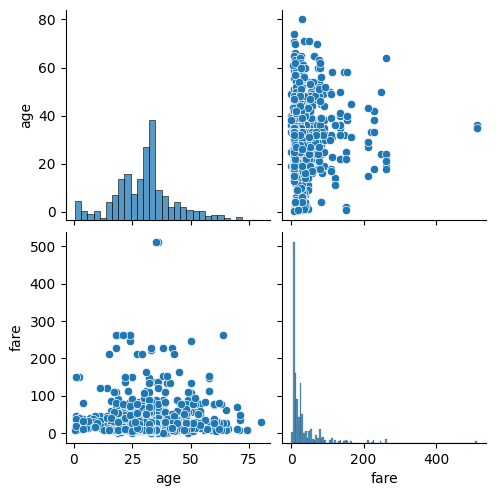

['fare']

In [49]:
# 4) plot_features_num_regression
# Nueva implementación

def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
    """
    Genera gráficos pairplot para las variables numéricas seleccionadas
    frente a la variable objetivo.

    Parámetros:
    df (pd.DataFrame): DataFrame con los datos.
    target_col (str, opcional): Nombre de la columna objetivo. Por defecto es una cadena vacía.
    columns (list, opcional): Lista de columnas numéricas a evaluar.
                              Por defecto es una lista vacía.
    umbral_corr (float, opcional): Umbral mínimo de correlación. Por defecto es 0.
    pvalue (float, opcional): Nivel de significancia estadística para el test de correlación.
                              Por defecto es None.

    Retorna:
    list: Lista de columnas que cumplen con las condiciones de correlación y significancia.
    """
    # Validaciones de entrada
    if not isinstance(df, pd.DataFrame):
        print("El argumento 'df' debe ser un DataFrame.")
        return None

    if target_col not in df.columns:
        print(f"La columna objetivo '{target_col}' no se encuentra en el DataFrame.")
        return None

    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"La columna objetivo '{target_col}' debe ser numérica.")
        return None

    if not (0 <= umbral_corr <= 1):
        print("El valor de 'umbral_corr' debe estar entre 0 y 1.")
        return None

    if pvalue is not None and not (0 <= pvalue <= 1):
        print("El valor de 'pvalue' debe estar entre 0 y 1.")
        return None

    # Si no se proporcionan columnas, seleccionamos todas las columnas numéricas 
    # excepto la columna objetivo
    if not columns:
        columns = df.select_dtypes(include=[np.number]).columns.drop(target_col).tolist()

    selected_features = []
    for col in columns:
        corr = df[target_col].corr(df[col])
        if abs(corr) >= umbral_corr:
            if pvalue is not None:
                _, p_val = pearsonr(df[target_col], df[col])
                if p_val < pvalue:
                    selected_features.append(col)
            else:
                selected_features.append(col)

    # Generación de gráficos pairplot en lotes de hasta 5 columnas
    max_features = 5
    for i in range(0, len(selected_features), max_features):
        subset = [target_col] + selected_features[i:i + max_features]
        sns.pairplot(df[subset])
        plt.show()

    return selected_features
plot_features_num_regression(df,"age",x,0,0.02)

 Genera gráficos pairplot para las variables numéricas seleccionadas
    frente a la variable objetivo.

    Parámetros:
    df (pd.DataFrame): DataFrame con los datos.
    target_col (str, opcional): Nombre de la columna objetivo. Por defecto es una cadena vacía.
    columns (list, opcional): Lista de columnas numéricas a evaluar.
                              Por defecto es una lista vacía.
    umbral_corr (float, opcional): Umbral mínimo de correlación. Por defecto es 0.
    pvalue (float, opcional): Nivel de significancia estadística para el test de correlación.
                              Por defecto es None.

    Retorna:
    list: Lista de columnas que cumplen con las condiciones de correlación y significancia.

In [9]:
#5 lista categoricas
def get_features_cat_regression(df, target_col, pvalue=0.05):
    """
    Devuelve la lista de columnas categóricas del DataFrame que tienen relación
    estadísticamente significativa con la columna numérica 'target_col'.
    Para cada columna categórica, se agrupan los valores de la variable objetivo
    y se realiza un test ANOVA o Kruskal-Wallis de forma simplificada.
    Argumentos:
    df (pd.DataFrame): El DataFrame de entrada.
    target_col (str): Nombre de la columna target (numérica) para la regresión.
    pvalue (float): Nivel de significación estadística. Por defecto, 0.05.
    Retorna:
    list or None: Lista de columnas categóricas que cumplen con el test estadístico
                  o None si hay errores en los argumentos.
    """
    # Comprobaciones de entrada
    if target_col not in df.columns:
        print(f"Error: La columna '{target_col}' no existe en el DataFrame.")
        return None
    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: La columna '{target_col}' no es numérica.")
        return None
    if not (0 < pvalue < 1):
        print("Error: pvalue debe estar entre 0 y 1.")
        return None
    # Filtramos columnas categóricas
    cat_cols = [col for col in df.columns
                if df[col].dtype == 'object'
                or df[col].dtype.name == 'category']
    selected_features = []
    for col in cat_cols:
        grupos = []
        for categoria in df[col].dropna().unique():
            grupos.append(df.loc[df[col] == categoria, target_col].dropna())
        if len(grupos) > 1:
            stat, p_val = f_oneway(*grupos)
            if np.isnan(p_val):
                stat, p_val = kruskal(*grupos)
            if p_val < pvalue:
                selected_features.append(col)
    return selected_features

z = get_features_cat_regression(df,"age", 0.02)
z

['sex', 'class', 'who', 'alive']

Devuelve la lista de columnas categóricas del DataFrame que tienen relación
    estadísticamente significativa con la columna numérica 'target_col'.
    Para cada columna categórica, se agrupan los valores de la variable objetivo
    y se realiza un test ANOVA o Kruskal-Wallis de forma simplificada.
    Argumentos:
    df (pd.DataFrame): El DataFrame de entrada.
    target_col (str): Nombre de la columna target (numérica) para la regresión.
    pvalue (float): Nivel de significación estadística. Por defecto, 0.05.
    Retorna:
    list or None: Lista de columnas categóricas que cumplen con el test estadístico
                  o None si hay errores en los argumentos.

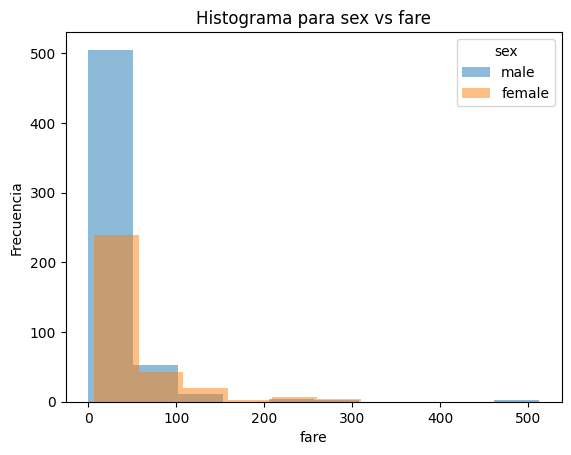

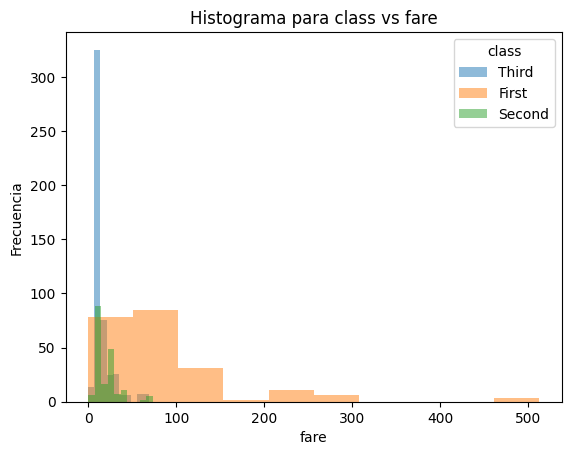

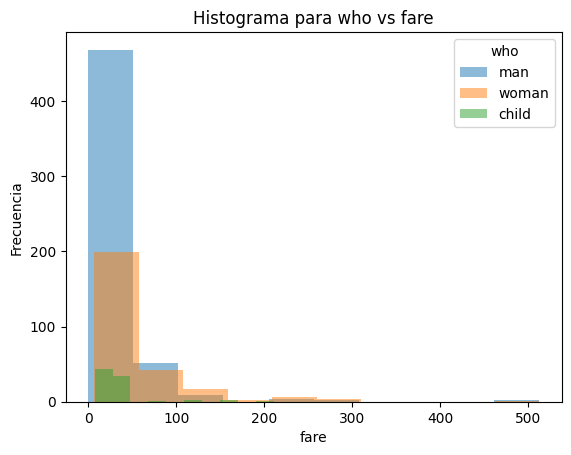

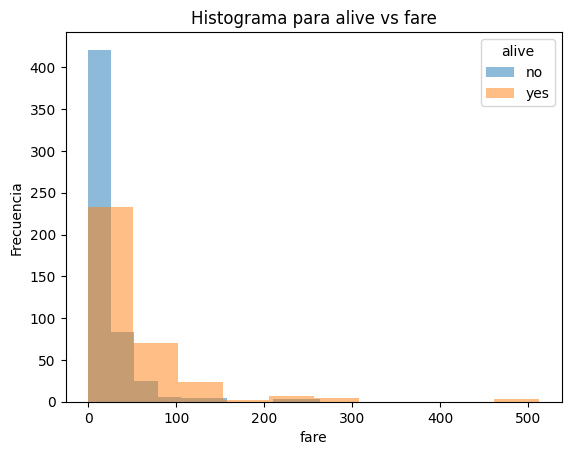

['sex', 'class', 'who', 'alive']

In [54]:

def plot_features_cat_regression(df, target_col = "", columns = [], p_value = 0.05, with_individual_plot = False):
    """
    Parámetros:
    df (pd.DataFrame): DataFrame que contiene las variables.
    target_Col(str, opcional): Nombre de la columna objetivo. Por defecto es una cadena vacía.
    columns(list, opcional): Lista de las columnas a categóricas a evaluar. Por defecto es una lista vacía.
    p_value(float, opcional): Nivel de significancia estadística para el test de correlación. Por defecto es 0.05.
    with_individual_plot(bool, opcional): Si es True, genera histogramas por categoría. Por defecto es False.
    Retorna:
    list: Lista de columnas (categóricas) que pasan el test de correlación.
    """
    #Validaciones de entrada
    if not isinstance(df, pd.DataFrame):
        print("Error: El argumento 'df' debe ser un dataframe de pandas")
        return None
    if not isinstance(target_col, str) or target_col not in df.columns:
        print("Error: 'target_col' debe ser una columna existente en el dataframe")
        return None
    if df[target_col].dtype not in ["float64","float32","int64","int32"]:
        print("Error: 'target_col' debe ser una columna numérica continua")
        return None
    if not isinstance(columns, list) or any(col not in df.columns for col in columns):
        print("Error: 'columns' debe ser una lista de nombre de columnas existentes en el dataframe")
        return None
    if not isinstance(p_value, (float, int)) or not (0 < p_value < 1):
        print("Error: 'p-value' debe ser un número entre 0 y 1")
        return None
    if not isinstance(with_individual_plot, bool):
        print("Error: 'with_individual_plot' debe ser un valor booleano")
        return None
    #Asignación de columnas categóricas
    if not columns:
        columns = [col for col in df.columns if col != target_col and df[col].dtype == "object" and df[col].nunique()]
    significant_columns = []
    for col in columns:
        if df[col].dtype == "object" or df[col].nunique() < 20:
            tabla_contigencia = pd.crosstab(df[col], df[target_col])
            try:
                _, p, _, _ = chi2_contingency(tabla_contigencia)
            except ValueError as e:
                print(f"Error al realizar el test estadístico en la columna '{col}': {e}")
                continue
            if p < p_value:
                significant_columns.append(col)
                if with_individual_plot:
                    for categoria in df[col].unique():
                        subset = df[df[col] == categoria][target_col]
                        plt.hist(subset, alpha = 0.5, label=str(categoria))
                    plt.title(f"Histograma para {col} vs {target_col}")
                    plt.xlabel(target_col)
                    plt.ylabel("Frecuencia")
                    plt.legend(title=col)
                    plt.show()
    return significant_columns
y = plot_features_cat_regression(df,"fare",z,0.05,True)
y

Parámetros:
    df (pd.DataFrame): DataFrame que contiene las variables.
    target_Col(str, opcional): Nombre de la columna objetivo. Por defecto es una cadena vacía.
    columns(list, opcional): Lista de las columnas a categóricas a evaluar. Por defecto es una lista vacía.
    p_value(float, opcional): Nivel de significancia estadística para el test de correlación. Por defecto es 0.05.
    with_individual_plot(bool, opcional): Si es True, genera histogramas por categoría. Por defecto es False.
    Retorna:
    list: Lista de columnas (categóricas) que pasan el test de correlación.